In [20]:
from matplotlib import pyplot as plt
import cv2 as cv
import numpy as np
import math

In [57]:
img1 = cv.imread('1.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('2.png', cv.IMREAD_GRAYSCALE)

In [58]:
def sad(a, b) :
    return np.mean(np.abs(a.astype(np.float64) - b.astype(np.float64)))

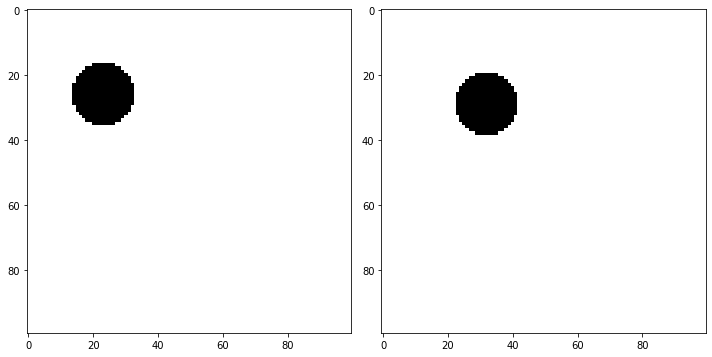

In [59]:
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(img1,  cmap='gray')
axes[1].imshow(img2, cmap='gray')
fig.tight_layout()

In [167]:
def draw_arrows(image, movement, block_size, color=(255,)):
    for i in range(movement.shape[0]):
        for j in range(movement.shape[1]):
            di, dj = movement[i, j]
            if di == 0 and dj == 0:
                continue
            start_point = (j * block_size + (block_size // 2),      i * block_size + (block_size // 2))
            end_point   = (j * block_size + (block_size // 2) + dj, i * block_size + (block_size // 2) + di)
            cv.arrowedLine(image, start_point, end_point, color)

In [205]:
def fullSearch(img_origin, img_mod, block_size=16, search_size=32) :

    movement = np.zeros(shape=(img_origin.shape[0], img_origin.shape[1], 2), dtype=np.int64)
        
    for i in range(0,img_origin.shape[0] - (search_size + block_size), block_size) :
        for j in range(0,img_origin.shape[1] - (search_size + block_size), block_size) :
            
            left_border   = j
            right_border  = j + block_size + 1
            bottom_border = i + block_size + 1
            top_border    = i

            rec_img_origin = img_origin[top_border:bottom_border, left_border:right_border]
            
            sad_min = -1
            k_min   = 0
            l_min   = 0
            
            for k in range(search_size) :
                for l in range(search_size) :
                    
                    left_border_mod   = l                  + i
                    right_border_mod  = l + block_size + 1 + i
                    bottom_border_mod = k + block_size + 1 + j
                    top_border_mod    = k                  + j

                    rec_img_mod = img_mod[top_border_mod:bottom_border_mod, left_border_mod:right_border_mod]
                    
                    sad_step = sad(rec_img_origin, rec_img_mod)
                    
                    if sad_step < sad_min or sad_min == -1 or \
                       sad_step * 0.9 < sad_min and k + l < k_min + l_min :
                        sad_min = sad_step
                        k_min   = k
                        l_min   = l
                          
            movement[i//block_size][j//block_size][0] = k_min
            movement[i//block_size][j//block_size][1] = l_min
            
    return movement

(100, 100, 2)


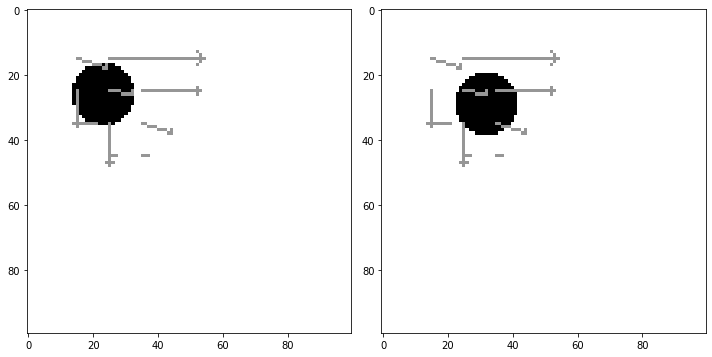

In [208]:
img1 = cv.imread('1.png', cv.IMREAD_GRAYSCALE)
img2 = cv.imread('2.png', cv.IMREAD_GRAYSCALE)

block_size  = 10
search_size = 30

movement = fullSearch(img1, img2, block_size, search_size)

print(movement.shape)
# print(movement)


draw_arrows(img1, movement, block_size, color=150)
draw_arrows(img2, movement, block_size, color=150)


fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].imshow(img1,  cmap='gray')
axes[1].imshow(img2, cmap='gray')
fig.tight_layout()